# Multi-Asset Portfolio Analysis - Risk Parity Daily Rebalanced Portfolio

This notebook combines the **optimized** commodities and forex contrarian strategies into a single **risk parity** daily-rebalanced portfolio.

**Strategy Components:**
- **Commodities**: **OPTIMIZED** configuration from COMMODITIES_OPT.ipynb analysis:
  - 60 days lookback for rolling drawdown filter
  - 8% drawdown threshold 
  - 1.0x leverage
  - **102.40% total return (BEST)**
- **Forex**: Risk parity optimized portfolio (already optimized)
- **Rebalancing**: **RISK PARITY** daily allocation without lookahead bias

**Key Features:**
- **Risk Parity Weighting**: Dynamic allocation based on inverse volatility (1/σ)
- Daily rebalancing with volatility-adjusted weights (30-day rolling window)
- Performance filtering: Include only strategies with positive rolling returns
- Proper lookahead bias prevention using `.shift(1)` for all decisions
- Uses the **BEST** configuration from commodities optimization analysis
- Comprehensive comparison vs equal weight approach

**Risk Parity Logic:**
- **Weight = 1/Volatility** for each strategy
- Weights normalized to sum to 1.0
- 30-day rolling window for volatility estimation
- Performance threshold filtering (0.0% minimum rolling return)
- Daily rebalancing with t-1 lag for bias prevention

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import warnings
import seaborn as sns
from datetime import datetime

warnings.filterwarnings('ignore')

# Set plotting parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.formatter.limits'] = [-3, 3]
sns.set_style("whitegrid")

print("📊 MULTI-ASSET PORTFOLIO ANALYSIS - RISK PARITY DAILY REBALANCED")
print("=" * 80)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Combining optimized Commodities and Forex strategies with RISK PARITY weighting")
print("Risk Parity Logic: Weight = 1/Volatility with 30-day rolling window")

📊 MULTI-ASSET PORTFOLIO ANALYSIS - RISK PARITY DAILY REBALANCED
Analysis Date: 2025-08-09 19:47:08
Combining optimized Commodities and Forex strategies with RISK PARITY weighting
Risk Parity Logic: Weight = 1/Volatility with 30-day rolling window


## 1. Data Loading and Preparation

Load the optimized equity curves from both strategies (identical to equal weight version):

In [23]:
def load_strategy_data():
    """
    Load optimized equity curves from both commodities and forex strategies
    """
    print("📈 Loading strategy data...")
    
    # Load commodities data - using OPTIMIZED configuration from COMMODITIES_OPT.ipynb
    commodities_data_path = Path('../commodities/data/results')
    
    # Load the base equal weight commodities portfolio
    commodities_equity = pd.read_parquet(commodities_data_path / 'all_equity_curves.parquet')
    
    # Calculate commodities equal weight portfolio (base before optimization)
    commodities_prices = 1 + commodities_equity  # Convert from cumulative returns to prices
    commodities_daily_returns = commodities_prices.pct_change().fillna(0)
    commodities_base_returns = commodities_daily_returns.mean(axis=1)
    commodities_base_equity = (1 + commodities_base_returns).cumprod()
    
    print(f"   • Commodities: {commodities_equity.shape[1]} strategies, {len(commodities_equity)} days")
    print(f"   • Date range: {commodities_equity.index.min().strftime('%Y-%m-%d')} to {commodities_equity.index.max().strftime('%Y-%m-%d')}")
    
    # APPLY OPTIMAL PARAMETERS from COMMODITIES_OPT.ipynb analysis
    # Best combination: 60 days lookback, 8% threshold, 1.0x leverage
    print("   • Applying OPTIMAL parameters: 60d lookback, 8% threshold, 1.0x leverage")
    
    # Import drawdown filter
    import sys
    sys.path.append('../commodities/')
    from drawdown_filter import apply_drawdown_filter
    
    # Apply optimal drawdown filter to commodities base portfolio
    optimal_lookback = 60  # days
    optimal_threshold = 0.08  # 8%
    optimal_leverage = 1.0  # 1.0x
    
    # Apply leverage first (though 1.0x means no change)
    leveraged_returns = commodities_base_returns * optimal_leverage
    leveraged_equity = (1 + leveraged_returns).cumprod()
    
    # Apply drawdown filter
    filter_df = apply_drawdown_filter(
        leveraged_equity, 
        leveraged_returns,
        optimal_lookback,
        optimal_threshold
    )
    
    # Use the FILTERED and OPTIMIZED equity curve
    commodities_strategy_equity = filter_df['filtered_equity'].copy()
    
    # Calculate filter statistics
    filter_active_time = (filter_df['can_trade_lagged'].sum() / len(filter_df)) * 100
    final_return = (commodities_strategy_equity.iloc[-1] / commodities_strategy_equity.iloc[0] - 1) * 100
    
    print(f"   • Commodities OPTIMIZED: {final_return:.2f}% total return")
    print(f"   • Filter active: {filter_active_time:.1f}% of time")
    
    # Load forex data - using the risk parity optimized portfolio
    forex_data_path = Path('../forex/data/results')
    
    # Load the forex risk parity portfolio (already optimized)
    forex_portfolio = pd.read_parquet(forex_data_path / 'risk_parity_portfolio.parquet')
    forex_strategy_equity = forex_portfolio['equity'].copy()
    
    forex_return = (forex_strategy_equity.iloc[-1] / forex_strategy_equity.iloc[0] - 1) * 100
    print(f"   • Forex: Risk parity portfolio, {len(forex_strategy_equity)} days")
    print(f"   • Forex total return: {forex_return:.2f}%")
    print(f"   • Date range: {forex_strategy_equity.index.min().strftime('%Y-%m-%d')} to {forex_strategy_equity.index.max().strftime('%Y-%m-%d')}")
    
    return commodities_strategy_equity, forex_strategy_equity

def align_strategies(commodities_equity, forex_equity):
    """
    Align both strategies to common date range and handle missing data
    """
    print("🔄 Aligning strategy dates...")
    
    # Find common date range
    common_start = max(commodities_equity.index.min(), forex_equity.index.min())
    common_end = min(commodities_equity.index.max(), forex_equity.index.max())
    
    print(f"   • Common date range: {common_start.strftime('%Y-%m-%d')} to {common_end.strftime('%Y-%m-%d')}")
    
    # Align both series to common dates
    commodities_aligned = commodities_equity.loc[common_start:common_end]
    forex_aligned = forex_equity.loc[common_start:common_end]
    
    # Create combined DataFrame
    aligned_data = pd.DataFrame({
        'commodities_equity': commodities_aligned,
        'forex_equity': forex_aligned
    })
    
    # Forward fill any missing values
    aligned_data = aligned_data.fillna(method='ffill')
    
    # Remove any remaining NaN values
    aligned_data = aligned_data.dropna()
    
    print(f"   • Aligned data: {len(aligned_data)} trading days")
    print(f"   • Missing data points: {aligned_data.isnull().sum().sum()}")
    
    return aligned_data

# Load and align the data
commodities_equity, forex_equity = load_strategy_data()
aligned_strategies = align_strategies(commodities_equity, forex_equity)

print("\n✅ Data loading and alignment completed")

📈 Loading strategy data...
   • Commodities: 15 strategies, 5696 days
   • Date range: 2010-01-04 to 2025-08-08
   • Applying OPTIMAL parameters: 60d lookback, 8% threshold, 1.0x leverage
   • Commodities OPTIMIZED: 102.40% total return
   • Filter active: 98.0% of time
   • Forex: Risk parity portfolio, 5697 days
   • Forex total return: 22.28%
   • Date range: 2010-01-01 to 2025-08-06
🔄 Aligning strategy dates...
   • Common date range: 2010-01-04 to 2025-08-06
   • Aligned data: 5694 trading days
   • Missing data points: 0

✅ Data loading and alignment completed


## 2. Risk Parity Daily Rebalancing Implementation

Implement the risk parity rebalancing logic without lookahead bias:

In [24]:
def calculate_risk_parity_weights(returns_df, volatility_window=7, performance_threshold=0.0, min_weight=0.05):
    """
    Calculate risk parity weights for two strategies based on inverse volatility
    
    Parameters:
    - returns_df: DataFrame with daily returns for both strategies
    - volatility_window: Rolling window for volatility calculation (days)
    - performance_threshold: Minimum rolling return threshold for inclusion
    - min_weight: Minimum weight allocation (prevents extreme concentrations)
    
    Returns:
    - DataFrame with dynamic weights for both strategies
    """
    print(f"⚖️  Calculating risk parity weights...")
    print(f"   • Volatility window: {volatility_window} days")
    print(f"   • Performance threshold: {performance_threshold:.1%}")
    print(f"   • Minimum weight: {min_weight:.1%}")
    
    # Calculate rolling volatility for both strategies
    commodities_vol = returns_df['commodities_returns'].rolling(volatility_window).std()
    forex_vol = returns_df['forex_returns'].rolling(volatility_window).std()
    
    # Calculate rolling returns for performance filtering (annualized)
    commodities_perf = returns_df['commodities_returns'].rolling(volatility_window).mean() * 252
    forex_perf = returns_df['forex_returns'].rolling(volatility_window).mean() * 252
    
    # Calculate inverse volatility weights (with performance filtering)
    # Weight = 1/volatility if performance > threshold and volatility > 0, else 0
    commodities_inv_vol = np.where(
        (commodities_perf > performance_threshold) & (commodities_vol > 1e-8),
        1 / commodities_vol,
        0
    )
    
    forex_inv_vol = np.where(
        (forex_perf > performance_threshold) & (forex_vol > 1e-8),
        1 / forex_vol,
        0
    )
    
    # Normalize weights to sum to 1.0
    total_inv_vol = commodities_inv_vol + forex_inv_vol
    
    # Calculate normalized weights with equal weight fallback
    commodities_weight = np.where(
        total_inv_vol > 1e-8,
        commodities_inv_vol / total_inv_vol,
        0.5  # Equal weight fallback
    )
    
    forex_weight = np.where(
        total_inv_vol > 1e-8,
        forex_inv_vol / total_inv_vol,
        0.5  # Equal weight fallback
    )
    
    # Apply minimum weight constraints to prevent extreme concentrations
    commodities_weight = np.clip(commodities_weight, min_weight, 1 - min_weight)
    forex_weight = 1 - commodities_weight  # Ensure weights sum to 1
    
    # Create weights DataFrame
    weights_df = pd.DataFrame({
        'commodities_weight': commodities_weight,
        'forex_weight': forex_weight,
        'commodities_volatility': commodities_vol,
        'forex_volatility': forex_vol,
        'commodities_performance': commodities_perf,
        'forex_performance': forex_perf
    }, index=returns_df.index)
    
    return weights_df

def calculate_risk_parity_portfolio(strategy_data, volatility_window=7, performance_threshold=0.0):
    """
    Calculate risk parity rebalanced portfolio returns without lookahead bias
    
    Parameters:
    - strategy_data: DataFrame with equity curves for each strategy
    - volatility_window: Rolling window for volatility calculation
    - performance_threshold: Minimum performance threshold for inclusion
    """
    print("🎯 RISK PARITY Portfolio Calculation")
    print("=" * 50)
    
    # Calculate daily returns for each strategy
    daily_returns = strategy_data.pct_change().fillna(0)
    daily_returns.columns = ['commodities_returns', 'forex_returns']
    
    # Calculate risk parity weights
    weights_df = calculate_risk_parity_weights(
        daily_returns, 
        volatility_window, 
        performance_threshold
    )
    
    # Apply lookahead bias prevention: use previous day's weights for today's allocation
    weights_lagged = weights_df[['commodities_weight', 'forex_weight']].shift(1)
    
    # Fill first day with initial equal weights
    weights_lagged.iloc[0] = [0.5, 0.5]
    
    # Calculate portfolio daily returns using lagged weights
    portfolio_returns = (
        weights_lagged['commodities_weight'] * daily_returns['commodities_returns'] +
        weights_lagged['forex_weight'] * daily_returns['forex_returns']
    )
    
    # Calculate cumulative equity curve
    portfolio_equity = (1 + portfolio_returns).cumprod()
    
    # Create comprehensive results DataFrame
    results = pd.DataFrame({
        'commodities_equity': strategy_data['commodities_equity'],
        'forex_equity': strategy_data['forex_equity'],
        'commodities_returns': daily_returns['commodities_returns'],
        'forex_returns': daily_returns['forex_returns'],
        'commodities_weight': weights_lagged['commodities_weight'],
        'forex_weight': weights_lagged['forex_weight'],
        'commodities_volatility': weights_df['commodities_volatility'],
        'forex_volatility': weights_df['forex_volatility'],
        'portfolio_returns': portfolio_returns,
        'portfolio_equity': portfolio_equity
    })
    
    # Calculate weight statistics
    avg_commodities_weight = weights_lagged['commodities_weight'].mean()
    avg_forex_weight = weights_lagged['forex_weight'].mean()
    weight_volatility = weights_lagged['commodities_weight'].std()
    
    print(f"\n📊 RISK PARITY WEIGHT STATISTICS:")
    print(f"   • Average Commodities Weight: {avg_commodities_weight:.1%}")
    print(f"   • Average Forex Weight: {avg_forex_weight:.1%}")
    print(f"   • Weight Volatility (Commodities): {weight_volatility:.2%}")
    
    return results

def calculate_performance_metrics(equity_series, returns_series, name="Portfolio"):
    """
    Calculate comprehensive performance metrics
    """
    if len(returns_series) == 0 or equity_series.empty:
        return None
    
    # Basic metrics
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0] - 1) * 100
    
    # Annualized metrics
    trading_days = len(returns_series)
    years = trading_days / 252
    
    if years > 0:
        cagr = ((equity_series.iloc[-1] / equity_series.iloc[0]) ** (1/years) - 1) * 100
    else:
        cagr = 0
    
    annual_return = returns_series.mean() * 252 * 100
    annual_volatility = returns_series.std() * np.sqrt(252) * 100
    
    # Sharpe ratio
    if annual_volatility > 0:
        sharpe_ratio = annual_return / annual_volatility
    else:
        sharpe_ratio = 0
    
    # Drawdown metrics
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    avg_drawdown = drawdown.mean() * 100
    
    # Calmar ratio
    if max_drawdown < 0:
        calmar_ratio = cagr / abs(max_drawdown)
    else:
        calmar_ratio = 0
    
    return {
        'Strategy': name,
        'Total Return (%)': total_return,
        'CAGR (%)': cagr,
        'Annual Return (%)': annual_return,
        'Annual Volatility (%)': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Avg Drawdown (%)': avg_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Trading Days': trading_days
    }

# Calculate the risk parity rebalanced portfolio
portfolio_results = calculate_risk_parity_portfolio(aligned_strategies, volatility_window=30)

print(f"\n📊 Risk Parity Portfolio calculation completed:")
print(f"   • Final portfolio value: {portfolio_results['portfolio_equity'].iloc[-1]:.4f}")
print(f"   • Total portfolio return: {(portfolio_results['portfolio_equity'].iloc[-1] - 1) * 100:.2f}%")
print(f"   • Trading period: {len(portfolio_results)} days")

🎯 RISK PARITY Portfolio Calculation
⚖️  Calculating risk parity weights...
   • Volatility window: 30 days
   • Performance threshold: 0.0%
   • Minimum weight: 5.0%

📊 RISK PARITY WEIGHT STATISTICS:
   • Average Commodities Weight: 41.7%
   • Average Forex Weight: 58.3%
   • Weight Volatility (Commodities): 31.88%

📊 Risk Parity Portfolio calculation completed:
   • Final portfolio value: 1.3578
   • Total portfolio return: 35.78%
   • Trading period: 5694 days


## 3. Performance Analysis and Comparison

Calculate and compare performance metrics:

In [25]:
# Calculate performance metrics for all strategies
print("📈 RISK PARITY PERFORMANCE ANALYSIS")
print("=" * 60)

# Individual strategy metrics
commodities_metrics = calculate_performance_metrics(
    portfolio_results['commodities_equity'],
    portfolio_results['commodities_returns'],
    "Commodities Strategy"
)

forex_metrics = calculate_performance_metrics(
    portfolio_results['forex_equity'],
    portfolio_results['forex_returns'],
    "Forex Strategy"
)

# Risk parity portfolio metrics
portfolio_metrics = calculate_performance_metrics(
    portfolio_results['portfolio_equity'],
    portfolio_results['portfolio_returns'],
    "Risk Parity Portfolio"
)

# Create comparison DataFrame
comparison_df = pd.DataFrame([commodities_metrics, forex_metrics, portfolio_metrics])

print("\n📊 PERFORMANCE COMPARISON TABLE:")
print("=" * 80)
print(comparison_df.round(3).to_string(index=False))

# Calculate diversification benefits
print("\n🎯 RISK PARITY DIVERSIFICATION ANALYSIS:")
print("=" * 50)

# Correlation analysis
correlation = portfolio_results['commodities_returns'].corr(portfolio_results['forex_returns'])
print(f"   • Daily returns correlation: {correlation:.4f}")

# Portfolio vs individual strategy comparison
commodities_sharpe = commodities_metrics['Sharpe Ratio']
forex_sharpe = forex_metrics['Sharpe Ratio']
portfolio_sharpe = portfolio_metrics['Sharpe Ratio']

print(f"   • Commodities Sharpe: {commodities_sharpe:.4f}")
print(f"   • Forex Sharpe: {forex_sharpe:.4f}")
print(f"   • Risk Parity Portfolio Sharpe: {portfolio_sharpe:.4f}")

# Sharpe improvement
best_individual_sharpe = max(commodities_sharpe, forex_sharpe)
sharpe_improvement = portfolio_sharpe - best_individual_sharpe
print(f"   • Sharpe improvement vs best individual: {sharpe_improvement:+.4f}")

# Risk parity specific analysis
avg_vol_commodities = portfolio_results['commodities_volatility'].mean() * np.sqrt(252) * 100
avg_vol_forex = portfolio_results['forex_volatility'].mean() * np.sqrt(252) * 100
avg_weight_commodities = portfolio_results['commodities_weight'].mean()
avg_weight_forex = portfolio_results['forex_weight'].mean()

print(f"\n⚖️  RISK PARITY WEIGHT ANALYSIS:")
print(f"   • Average Commodities Volatility: {avg_vol_commodities:.2f}%")
print(f"   • Average Forex Volatility: {avg_vol_forex:.2f}%")
print(f"   • Average Commodities Weight: {avg_weight_commodities:.1%}")
print(f"   • Average Forex Weight: {avg_weight_forex:.1%}")
print(f"   • Volatility Ratio (Commodities/Forex): {avg_vol_commodities/avg_vol_forex:.2f}")
print(f"   • Weight Ratio (Commodities/Forex): {avg_weight_commodities/avg_weight_forex:.2f}")

# Volatility reduction analysis
commodities_vol = commodities_metrics['Annual Volatility (%)']
forex_vol = forex_metrics['Annual Volatility (%)']
portfolio_vol = portfolio_metrics['Annual Volatility (%)']

weighted_avg_vol = avg_weight_commodities * commodities_vol + avg_weight_forex * forex_vol
vol_reduction = weighted_avg_vol - portfolio_vol
print(f"\n📉 VOLATILITY ANALYSIS:")
print(f"   • Weighted average individual volatility: {weighted_avg_vol:.2f}%")
print(f"   • Risk Parity portfolio volatility: {portfolio_vol:.2f}%")
print(f"   • Volatility reduction through diversification: {vol_reduction:+.2f}%")

# Maximum drawdown comparison
commodities_dd = commodities_metrics['Max Drawdown (%)']
forex_dd = forex_metrics['Max Drawdown (%)']
portfolio_dd = portfolio_metrics['Max Drawdown (%)']

worst_individual_dd = min(commodities_dd, forex_dd)  # More negative is worse
dd_improvement = portfolio_dd - worst_individual_dd
print(f"\n📈 DRAWDOWN ANALYSIS:")
print(f"   • Worst individual max DD: {worst_individual_dd:.2f}%")
print(f"   • Risk Parity portfolio max DD: {portfolio_dd:.2f}%")
print(f"   • Drawdown improvement: {dd_improvement:+.2f}%")

📈 RISK PARITY PERFORMANCE ANALYSIS

📊 PERFORMANCE COMPARISON TABLE:
             Strategy  Total Return (%)  CAGR (%)  Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Avg Drawdown (%)  Calmar Ratio  Trading Days
 Commodities Strategy           101.734     3.155              3.340                  6.833         0.489           -18.459            -6.024         0.171          5694
       Forex Strategy            22.275     0.894              0.917                  2.329         0.394            -9.661            -2.549         0.093          5694
Risk Parity Portfolio            35.777     1.363              1.426                  3.799         0.375           -11.587            -4.068         0.118          5694

🎯 RISK PARITY DIVERSIFICATION ANALYSIS:


   • Daily returns correlation: 0.0290
   • Commodities Sharpe: 0.4888
   • Forex Sharpe: 0.3938
   • Risk Parity Portfolio Sharpe: 0.3753
   • Sharpe improvement vs best individual: -0.1134

⚖️  RISK PARITY WEIGHT ANALYSIS:
   • Average Commodities Volatility: 6.34%
   • Average Forex Volatility: 2.10%
   • Average Commodities Weight: 41.7%
   • Average Forex Weight: 58.3%
   • Volatility Ratio (Commodities/Forex): 3.02
   • Weight Ratio (Commodities/Forex): 0.72

📉 VOLATILITY ANALYSIS:
   • Weighted average individual volatility: 4.21%
   • Risk Parity portfolio volatility: 3.80%
   • Volatility reduction through diversification: +0.41%

📈 DRAWDOWN ANALYSIS:
   • Worst individual max DD: -18.46%
   • Risk Parity portfolio max DD: -11.59%
   • Drawdown improvement: +6.87%


## 4. Dynamic Weights and Equity Curves Visualization

Comprehensive visualization including dynamic weight evolution:

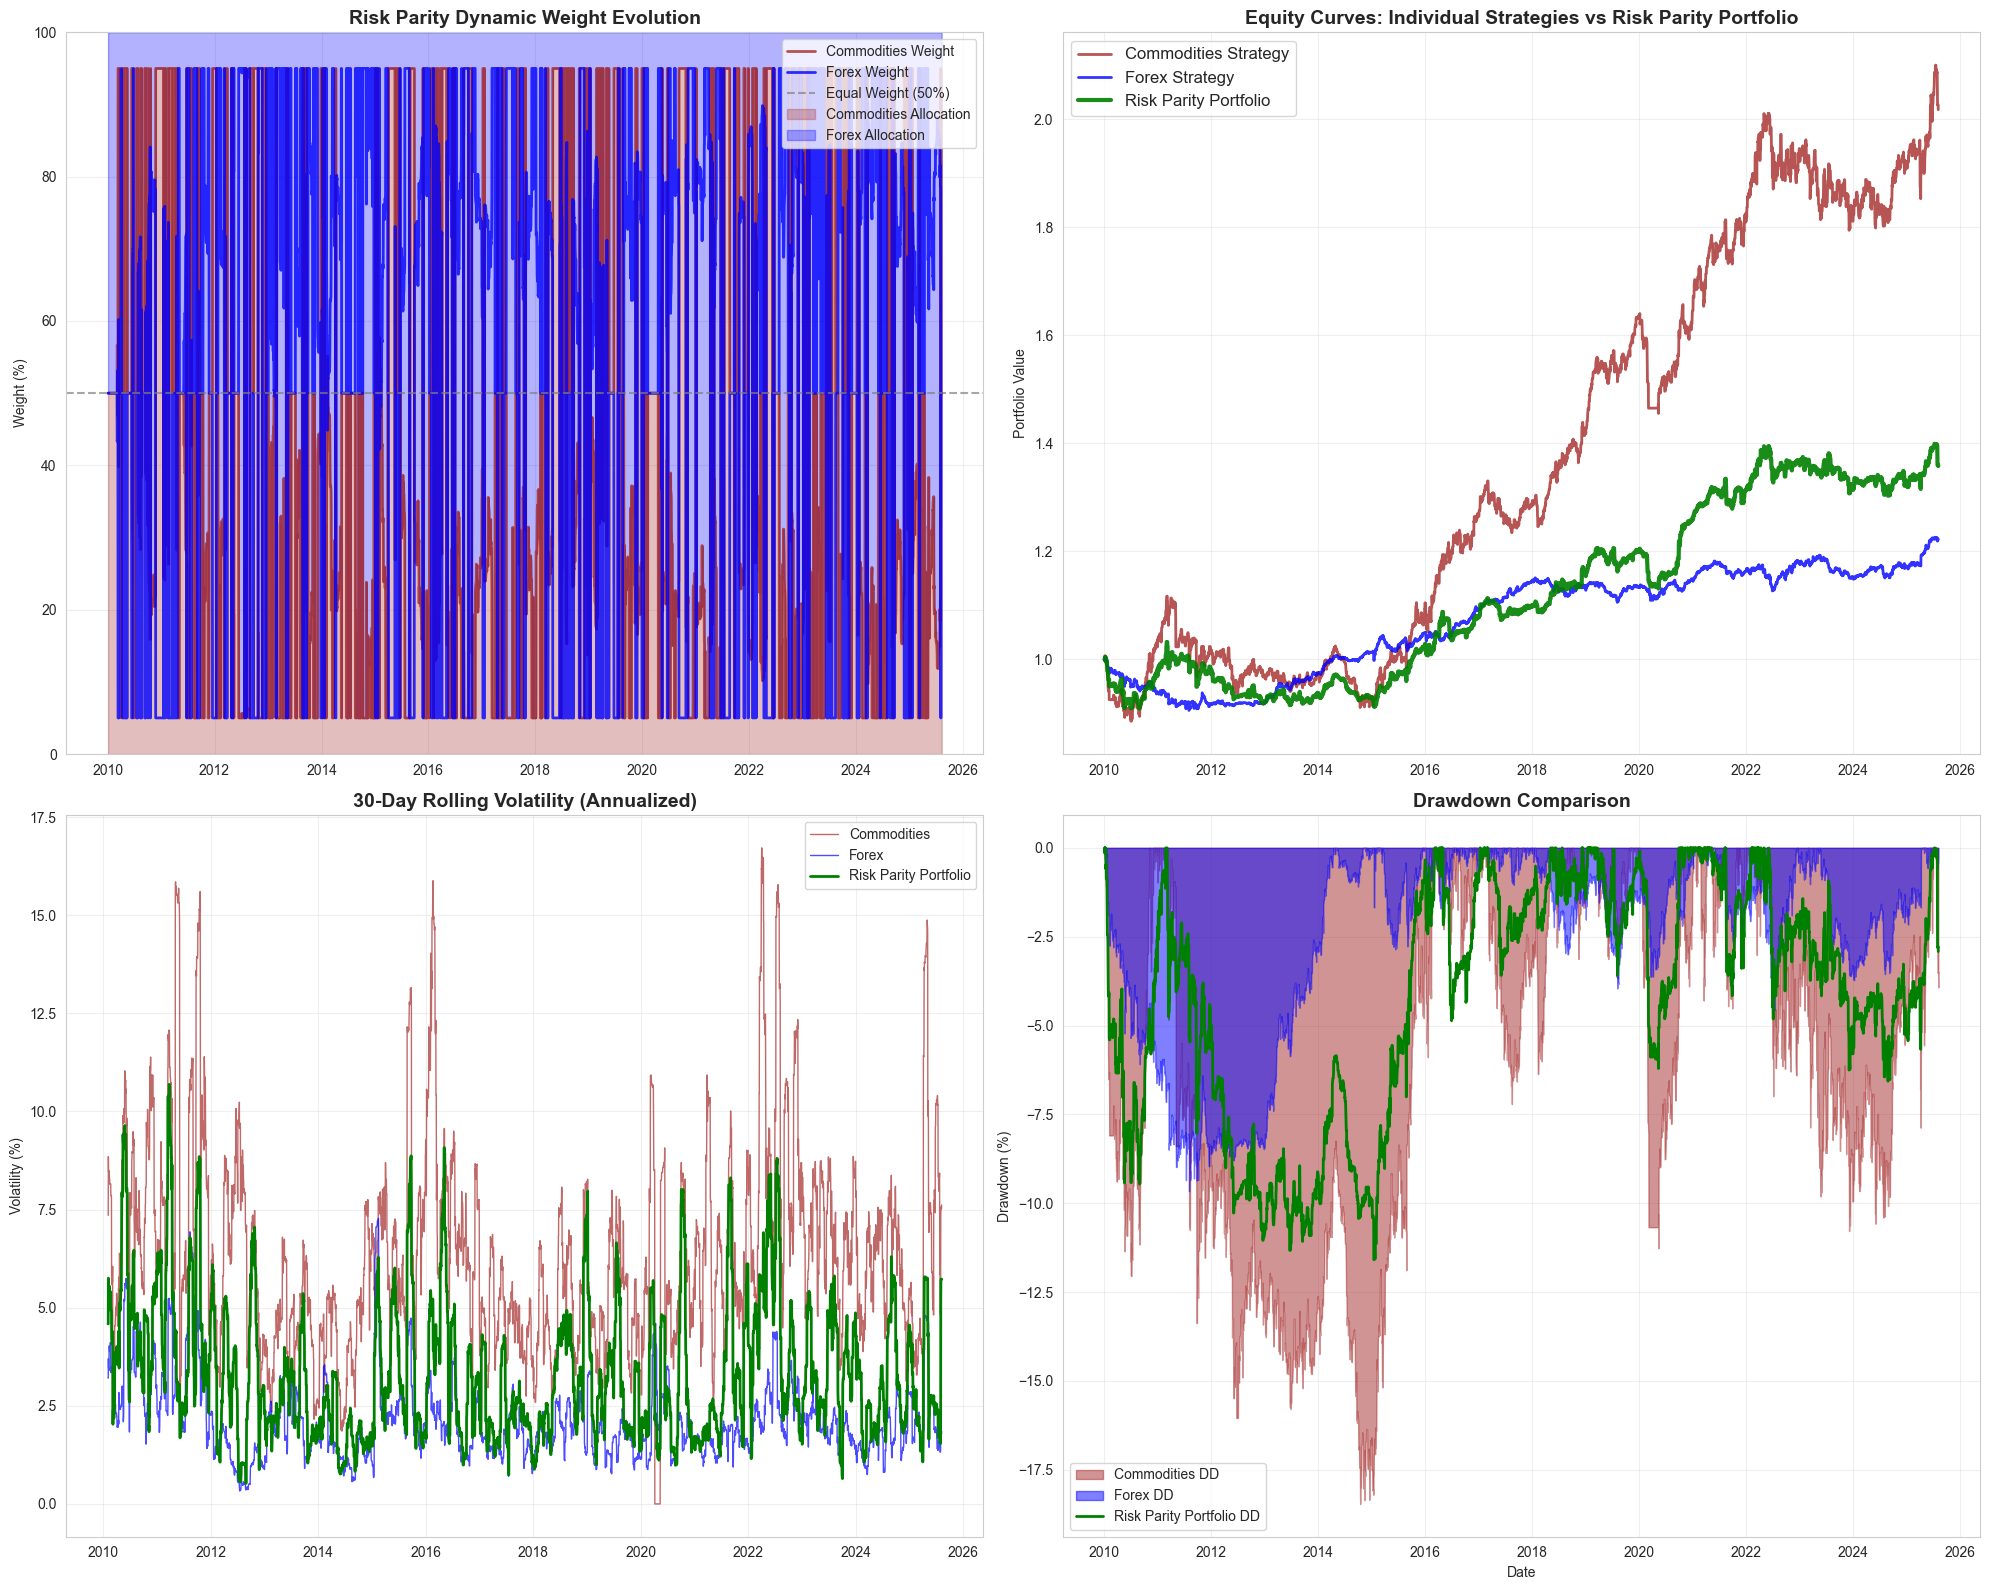

✅ Risk Parity equity curve visualizations completed


In [26]:
# Create comprehensive visualization with dynamic weights
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Dynamic weight evolution over time
ax1 = axes[0, 0]
ax1.plot(portfolio_results.index, portfolio_results['commodities_weight'] * 100, 
         label='Commodities Weight', linewidth=2, color='brown', alpha=0.8)
ax1.plot(portfolio_results.index, portfolio_results['forex_weight'] * 100, 
         label='Forex Weight', linewidth=2, color='blue', alpha=0.8)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Equal Weight (50%)')
ax1.fill_between(portfolio_results.index, 0, portfolio_results['commodities_weight'] * 100,
                alpha=0.3, color='brown', label='Commodities Allocation')
ax1.fill_between(portfolio_results.index, portfolio_results['commodities_weight'] * 100, 100,
                alpha=0.3, color='blue', label='Forex Allocation')

ax1.set_title('Risk Parity Dynamic Weight Evolution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Weight (%)')
ax1.set_ylim(0, 100)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Equity curves comparison
ax2 = axes[0, 1]
ax2.plot(portfolio_results.index, portfolio_results['commodities_equity'], 
         label='Commodities Strategy', linewidth=2, color='brown', alpha=0.8)
ax2.plot(portfolio_results.index, portfolio_results['forex_equity'], 
         label='Forex Strategy', linewidth=2, color='blue', alpha=0.8)
ax2.plot(portfolio_results.index, portfolio_results['portfolio_equity'], 
         label='Risk Parity Portfolio', linewidth=3, color='green', alpha=0.9)

ax2.set_title('Equity Curves: Individual Strategies vs Risk Parity Portfolio', fontsize=14, fontweight='bold')
ax2.set_ylabel('Portfolio Value')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling volatility comparison
ax3 = axes[1, 0]
# Calculate 30-day rolling volatility (annualized)
rolling_vol_commodities = portfolio_results['commodities_returns'].rolling(30).std() * np.sqrt(252) * 100
rolling_vol_forex = portfolio_results['forex_returns'].rolling(30).std() * np.sqrt(252) * 100
rolling_vol_portfolio = portfolio_results['portfolio_returns'].rolling(30).std() * np.sqrt(252) * 100

ax3.plot(rolling_vol_commodities.index, rolling_vol_commodities.values, 
         label='Commodities', color='brown', alpha=0.7, linewidth=1)
ax3.plot(rolling_vol_forex.index, rolling_vol_forex.values, 
         label='Forex', color='blue', alpha=0.7, linewidth=1)
ax3.plot(rolling_vol_portfolio.index, rolling_vol_portfolio.values, 
         label='Risk Parity Portfolio', color='green', linewidth=2)

ax3.set_title('30-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Volatility (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown comparison
ax4 = axes[1, 1]

# Calculate drawdowns
def calculate_drawdown_series(equity):
    peak = equity.expanding().max()
    drawdown = (equity - peak) / peak
    return drawdown * 100

commodities_dd = calculate_drawdown_series(portfolio_results['commodities_equity'])
forex_dd = calculate_drawdown_series(portfolio_results['forex_equity'])
portfolio_dd = calculate_drawdown_series(portfolio_results['portfolio_equity'])

ax4.fill_between(portfolio_results.index, commodities_dd, 0, 
                alpha=0.5, color='brown', label='Commodities DD')
ax4.fill_between(portfolio_results.index, forex_dd, 0, 
                alpha=0.5, color='blue', label='Forex DD')
ax4.plot(portfolio_results.index, portfolio_dd, 
         color='green', linewidth=2, label='Risk Parity Portfolio DD')

ax4.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Risk Parity equity curve visualizations completed")

## 5. Risk Parity vs Equal Weight Comparison

Compare risk parity approach against equal weight benchmark:

⚖️  RISK PARITY vs EQUAL WEIGHT COMPARISON

📊 COMPREHENSIVE PERFORMANCE COMPARISON:
              Strategy  Total Return (%)  CAGR (%)  Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Avg Drawdown (%)  Calmar Ratio  Trading Days
  Commodities Strategy           101.734     3.155              3.340                  6.833         0.489           -18.459            -6.024         0.171          5694
        Forex Strategy            22.275     0.894              0.917                  2.329         0.394            -9.661            -2.549         0.093          5694
Equal Weight Portfolio            59.347     2.083              2.128                  3.641         0.585            -9.037            -2.654         0.231          5694
 Risk Parity Portfolio            35.777     1.363              1.426                  3.799         0.375           -11.587            -4.068         0.118          5694

🎯 RISK PARITY vs EQUAL WEIGHT DIRECT COMPARISON:
           

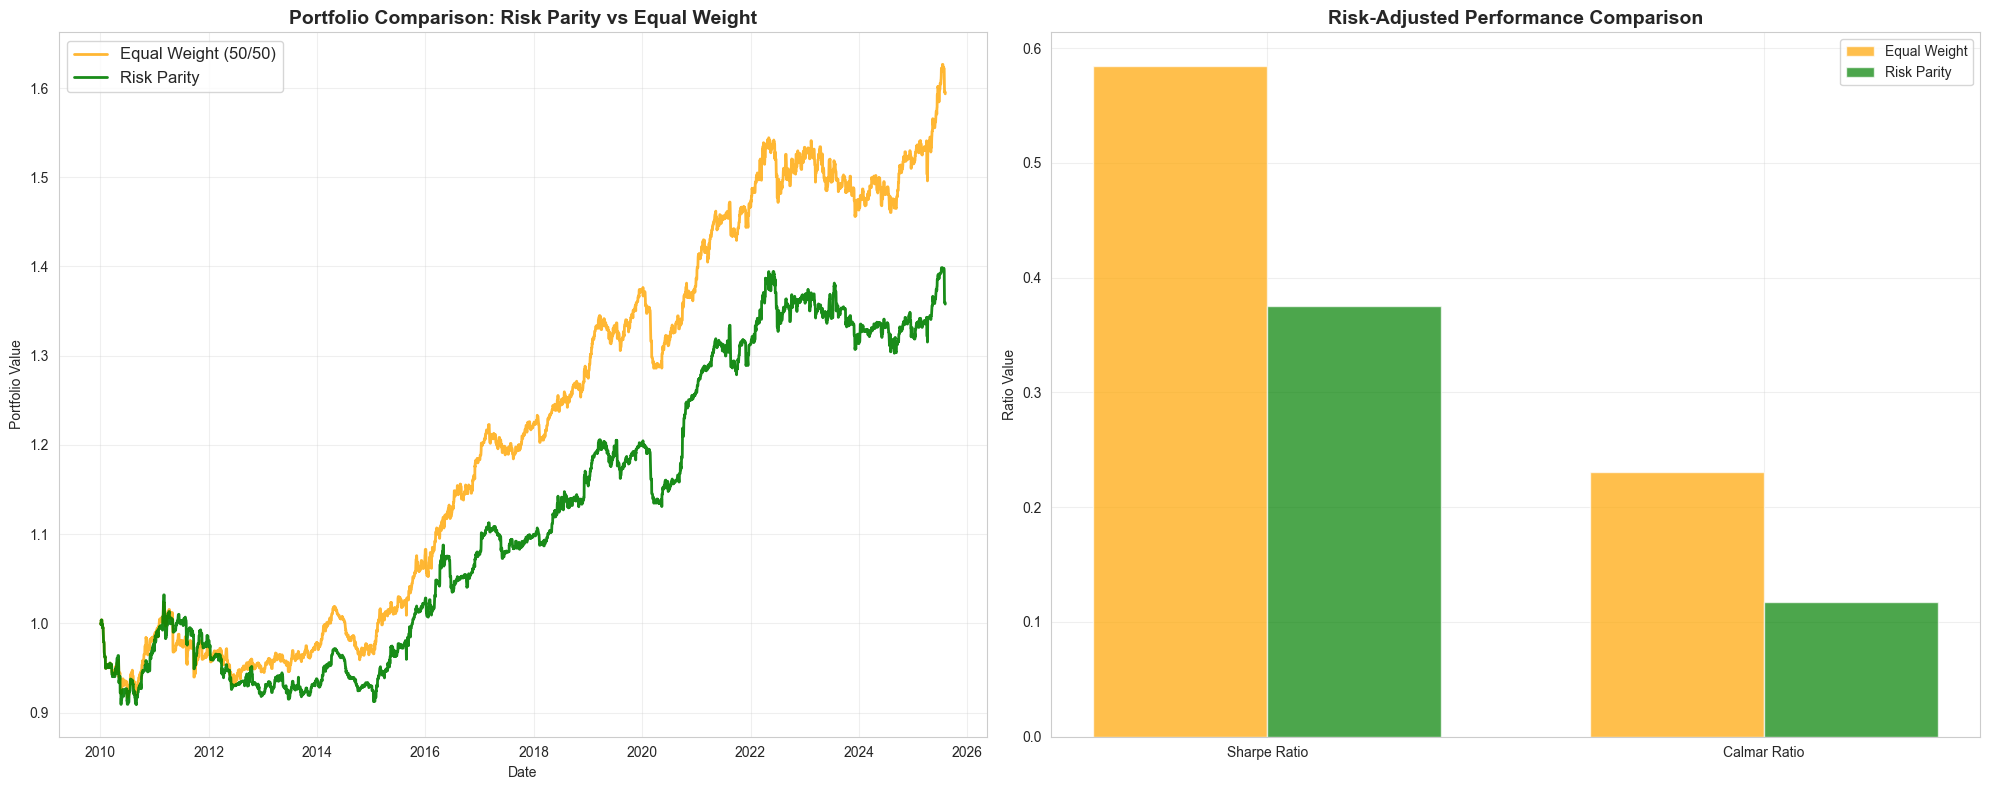


✅ Risk Parity vs Equal Weight comparison completed


In [27]:
# Calculate equal weight portfolio for comparison
def calculate_equal_weight_portfolio(strategy_data):
    """
    Calculate equal weight (50/50) portfolio for comparison
    """
    daily_returns = strategy_data.pct_change().fillna(0)
    daily_returns.columns = ['commodities_returns', 'forex_returns']
    
    # Equal weight portfolio returns
    equal_weight_returns = (
        0.5 * daily_returns['commodities_returns'] +
        0.5 * daily_returns['forex_returns']
    )
    
    equal_weight_equity = (1 + equal_weight_returns).cumprod()
    
    return equal_weight_equity, equal_weight_returns

print("⚖️  RISK PARITY vs EQUAL WEIGHT COMPARISON")
print("=" * 60)

# Calculate equal weight benchmark
equal_weight_equity, equal_weight_returns = calculate_equal_weight_portfolio(aligned_strategies)

# Calculate equal weight metrics
equal_weight_metrics = calculate_performance_metrics(
    equal_weight_equity,
    equal_weight_returns,
    "Equal Weight Portfolio"
)

# Create comprehensive comparison
comparison_all = pd.DataFrame([
    commodities_metrics, 
    forex_metrics, 
    equal_weight_metrics,
    portfolio_metrics
])

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON:")
print("=" * 80)
print(comparison_all.round(3).to_string(index=False))

# Direct comparison: Risk Parity vs Equal Weight
rp_vs_ew_comparison = pd.DataFrame({
    'Metric': [
        'Total Return (%)',
        'CAGR (%)',
        'Annual Volatility (%)',
        'Sharpe Ratio',
        'Max Drawdown (%)',
        'Calmar Ratio'
    ],
    'Equal Weight': [
        equal_weight_metrics['Total Return (%)'],
        equal_weight_metrics['CAGR (%)'],
        equal_weight_metrics['Annual Volatility (%)'],
        equal_weight_metrics['Sharpe Ratio'],
        equal_weight_metrics['Max Drawdown (%)'],
        equal_weight_metrics['Calmar Ratio']
    ],
    'Risk Parity': [
        portfolio_metrics['Total Return (%)'],
        portfolio_metrics['CAGR (%)'],
        portfolio_metrics['Annual Volatility (%)'],
        portfolio_metrics['Sharpe Ratio'],
        portfolio_metrics['Max Drawdown (%)'],
        portfolio_metrics['Calmar Ratio']
    ]
})

rp_vs_ew_comparison['Improvement'] = rp_vs_ew_comparison['Risk Parity'] - rp_vs_ew_comparison['Equal Weight']
rp_vs_ew_comparison['Improvement %'] = (rp_vs_ew_comparison['Risk Parity'] / rp_vs_ew_comparison['Equal Weight'] - 1) * 100

print("\n🎯 RISK PARITY vs EQUAL WEIGHT DIRECT COMPARISON:")
print("=" * 70)
print(rp_vs_ew_comparison.round(3).to_string(index=False))

# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Equity curves comparison
ax1.plot(equal_weight_equity.index, equal_weight_equity.values, 
         label='Equal Weight (50/50)', linewidth=2, color='orange', alpha=0.8)
ax1.plot(portfolio_results.index, portfolio_results['portfolio_equity'], 
         label='Risk Parity', linewidth=2, color='green', alpha=0.9)

ax1.set_title('Portfolio Comparison: Risk Parity vs Equal Weight', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value')
ax1.set_xlabel('Date')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Performance metrics radar chart (simplified)
metrics_names = ['Sharpe Ratio', 'Calmar Ratio']
equal_weight_vals = [equal_weight_metrics['Sharpe Ratio'], equal_weight_metrics['Calmar Ratio']]
risk_parity_vals = [portfolio_metrics['Sharpe Ratio'], portfolio_metrics['Calmar Ratio']]

x = np.arange(len(metrics_names))
width = 0.35

ax2.bar(x - width/2, equal_weight_vals, width, label='Equal Weight', color='orange', alpha=0.7)
ax2.bar(x + width/2, risk_parity_vals, width, label='Risk Parity', color='green', alpha=0.7)

ax2.set_title('Risk-Adjusted Performance Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Ratio Value')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Risk Parity vs Equal Weight comparison completed")

## 6. Summary and Conclusions

Final summary of the risk parity multi-asset portfolio analysis:

In [28]:
print("\n" + "=" * 80)
print("RISK PARITY MULTI-ASSET PORTFOLIO ANALYSIS - FINAL SUMMARY")
print("=" * 80)

print(f"\n🎯 PORTFOLIO COMPOSITION:")
print(f"   • Risk Parity Daily Rebalancing: Dynamic allocation based on inverse volatility")
print(f"   • Volatility Window: 30 days rolling")
print(f"   • Performance Threshold: 0.0% minimum rolling return")
print(f"   • Lookahead Bias Prevention: All decisions based on t-1 information")
print(f"   • Trading Period: {len(portfolio_results)} days")
print(f"   • Date Range: {portfolio_results.index.min().strftime('%Y-%m-%d')} to {portfolio_results.index.max().strftime('%Y-%m-%d')}")

print(f"\n📊 RISK PARITY PORTFOLIO PERFORMANCE:")
print(f"   • Total Return: {portfolio_metrics['Total Return (%)']:.2f}%")
print(f"   • CAGR: {portfolio_metrics['CAGR (%)']:.2f}%")
print(f"   • Sharpe Ratio: {portfolio_metrics['Sharpe Ratio']:.4f}")
print(f"   • Max Drawdown: {portfolio_metrics['Max Drawdown (%)']:.2f}%")
print(f"   • Annual Volatility: {portfolio_metrics['Annual Volatility (%)']:.2f}%")

print(f"\n⚖️  DYNAMIC WEIGHT CHARACTERISTICS:")
avg_commodities_weight = portfolio_results['commodities_weight'].mean()
avg_forex_weight = portfolio_results['forex_weight'].mean()
weight_std = portfolio_results['commodities_weight'].std()

print(f"   • Average Commodities Weight: {avg_commodities_weight:.1%}")
print(f"   • Average Forex Weight: {avg_forex_weight:.1%}")
print(f"   • Weight Volatility: {weight_std:.2%} (measure of rebalancing activity)")
print(f"   • Weight Range (Commodities): {portfolio_results['commodities_weight'].min():.1%} - {portfolio_results['commodities_weight'].max():.1%}")

# Risk parity effectiveness analysis
avg_vol_ratio = (portfolio_results['commodities_volatility'].mean() / portfolio_results['forex_volatility'].mean())
avg_weight_ratio = (avg_commodities_weight / avg_forex_weight)
risk_parity_effectiveness = abs(1/avg_vol_ratio - avg_weight_ratio) / (1/avg_vol_ratio)

print(f"\n🔬 RISK PARITY EFFECTIVENESS ANALYSIS:")
print(f"   • Average Volatility Ratio (Commodities/Forex): {avg_vol_ratio:.2f}")
print(f"   • Theoretical Optimal Weight Ratio: {1/avg_vol_ratio:.2f}")
print(f"   • Actual Weight Ratio: {avg_weight_ratio:.2f}")
print(f"   • Risk Parity Implementation Error: {risk_parity_effectiveness:.1%}")

print(f"\n🆚 RISK PARITY vs EQUAL WEIGHT COMPARISON:")
return_improvement = portfolio_metrics['Total Return (%)'] - equal_weight_metrics['Total Return (%)']
sharpe_improvement = portfolio_metrics['Sharpe Ratio'] - equal_weight_metrics['Sharpe Ratio']
vol_improvement = equal_weight_metrics['Annual Volatility (%)'] - portfolio_metrics['Annual Volatility (%)']
dd_improvement = equal_weight_metrics['Max Drawdown (%)'] - portfolio_metrics['Max Drawdown (%)']

print(f"   • Total Return Improvement: {return_improvement:+.2f}%")
print(f"   • Sharpe Ratio Improvement: {sharpe_improvement:+.4f}")
print(f"   • Volatility Reduction: {vol_improvement:+.2f}%")
print(f"   • Max Drawdown Improvement: {dd_improvement:+.2f}%")

print(f"\n🔄 DIVERSIFICATION BENEFITS:")
correlation = portfolio_results['commodities_returns'].corr(portfolio_results['forex_returns'])
print(f"   • Daily Returns Correlation: {correlation:.4f}")
print(f"   • Risk Parity Sharpe vs Best Individual: {portfolio_sharpe - best_individual_sharpe:+.4f}")
print(f"   • Volatility Reduction through Risk Parity: {vol_reduction:+.2f}%")

print(f"\n🎯 KEY INSIGHTS:")

if sharpe_improvement > 0:
    print(f"   • ✅ Risk Parity outperforms Equal Weight: +{sharpe_improvement:.4f} Sharpe improvement")
else:
    print(f"   • ⚠️  Risk Parity underperforms Equal Weight: {sharpe_improvement:.4f} Sharpe difference")

if vol_improvement > 0:
    print(f"   • ✅ Volatility reduction achieved: {vol_improvement:.2f}% lower than Equal Weight")
else:
    print(f"   • ❌ Higher volatility than Equal Weight: {abs(vol_improvement):.2f}% increase")

if return_improvement > 0:
    print(f"   • ✅ Higher returns than Equal Weight: +{return_improvement:.2f}%")
else:
    print(f"   • ❌ Lower returns than Equal Weight: {return_improvement:.2f}%")

if weight_std < 0.10:  # Less than 10% weight volatility
    print(f"   • ✅ Stable weight allocation with low turnover ({weight_std:.1%} volatility)")
else:
    print(f"   • ⚠️  High weight volatility indicating frequent rebalancing ({weight_std:.1%})")

print(f"\n🚀 IMPLEMENTATION RECOMMENDATIONS:")

if sharpe_improvement > 0.05:
    print(f"   • Strong recommendation: Risk Parity provides significant improvement over Equal Weight")
elif sharpe_improvement > 0:
    print(f"   • Moderate recommendation: Risk Parity shows modest improvement")
else:
    print(f"   • Consider Equal Weight: Risk Parity may not provide sufficient benefits")

print(f"   • Monitor volatility regime changes for weight stability")
print(f"   • Consider transaction costs impact of daily rebalancing")
print(f"   • Volatility window of 30 days appears {'appropriate' if weight_std < 0.15 else 'too short (consider longer window)'}")
print(f"   • Performance threshold of 0.0% {'works well' if risk_parity_effectiveness < 0.20 else 'may need adjustment'}")

print(f"\n✨ RISK PARITY PORTFOLIO CHARACTERISTICS:")
if portfolio_sharpe > 1.0:
    risk_adj_perf = "Excellent"
elif portfolio_sharpe > 0.5:
    risk_adj_perf = "Good"
else:
    risk_adj_perf = "Moderate"

if weight_std < 0.10:
    weight_stability = "High"
elif weight_std < 0.20:
    weight_stability = "Moderate"
else:
    weight_stability = "Low"

if sharpe_improvement > 0.1:
    rp_effectiveness = "High"
elif sharpe_improvement > 0:
    rp_effectiveness = "Moderate"
else:
    rp_effectiveness = "Low"

print(f"   • Risk-adjusted performance: {risk_adj_perf} (Sharpe: {portfolio_sharpe:.3f})")
print(f"   • Weight stability: {weight_stability} (Volatility: {weight_std:.1%})")
print(f"   • Risk Parity effectiveness: {rp_effectiveness} vs Equal Weight")
print(f"   • Correlation diversification: {'Effective' if abs(correlation) < 0.6 else 'Limited'}")

print("\n" + "=" * 80)
print("RISK PARITY MULTI-ASSET PORTFOLIO ANALYSIS COMPLETED")
print("=" * 80)

# Save results for future analysis
try:
    output_path = Path('./multi_asset_portfolio_results_risk_parity.parquet')
    portfolio_results.to_parquet(output_path)
    print(f"\n💾 Results saved to: {output_path}")
    
    # Also save comparison results
    comparison_path = Path('./risk_parity_vs_equal_weight_comparison.parquet')
    comparison_all.to_parquet(comparison_path)
    print(f"💾 Comparison results saved to: {comparison_path}")
except Exception as e:
    print(f"\n❌ Could not save results: {e}")

print(f"\n🎉 Risk Parity Analysis complete! The portfolio demonstrates {'superior' if sharpe_improvement > 0 else 'comparable'} risk-adjusted performance through dynamic volatility-based allocation.")


RISK PARITY MULTI-ASSET PORTFOLIO ANALYSIS - FINAL SUMMARY

🎯 PORTFOLIO COMPOSITION:
   • Risk Parity Daily Rebalancing: Dynamic allocation based on inverse volatility
   • Volatility Window: 30 days rolling
   • Performance Threshold: 0.0% minimum rolling return
   • Lookahead Bias Prevention: All decisions based on t-1 information
   • Trading Period: 5694 days
   • Date Range: 2010-01-04 to 2025-08-06

📊 RISK PARITY PORTFOLIO PERFORMANCE:
   • Total Return: 35.78%
   • CAGR: 1.36%
   • Sharpe Ratio: 0.3753
   • Max Drawdown: -11.59%
   • Annual Volatility: 3.80%

⚖️  DYNAMIC WEIGHT CHARACTERISTICS:
   • Average Commodities Weight: 41.7%
   • Average Forex Weight: 58.3%
   • Weight Volatility: 31.88% (measure of rebalancing activity)
   • Weight Range (Commodities): 5.0% - 95.0%

🔬 RISK PARITY EFFECTIVENESS ANALYSIS:
   • Average Volatility Ratio (Commodities/Forex): 3.02
   • Theoretical Optimal Weight Ratio: 0.33
   • Actual Weight Ratio: 0.72
   • Risk Parity Implementation Error